# Text Classification Using the 20 Newsgroups Dataset
The 20 Newsgroups dataset is a collection of about 20,000 examples into 20 unqiue categories. This is popularly known for machine learning tutorials with text like clustering and classification. More information about the 20 Newsgroup data can be found at the links in my resources section. 

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn

import os 
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

%matplotlib inline
w = 12
h = 9
plt.rcParams["figure.figsize"] = (w,h)

Using TensorFlow backend.


## Data

The training and test split have very good class distribution, this can be shown in the following plots. Class 18, 19 and 0 have slightly less presence compared to the others but it's not greatly imbalanced. This is preferred for our training. 

Training size: 11314
Test size: 7532
Percentage: 0.66572388191621


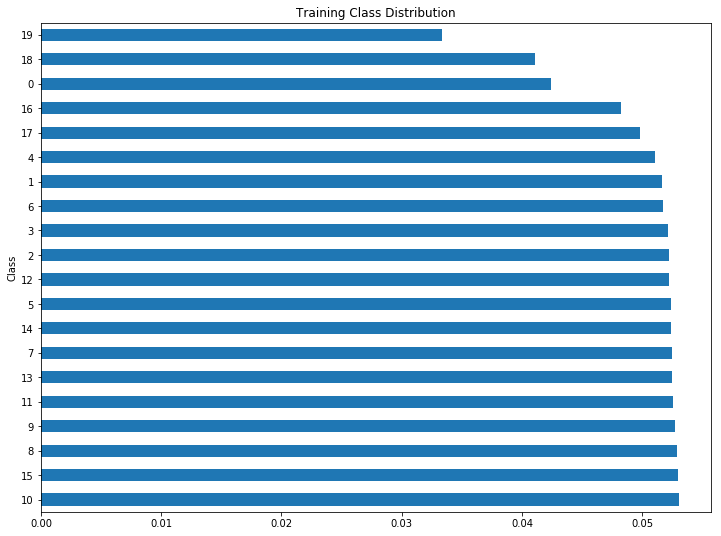

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

print('Training size: {}'.format(len(newsgroups_train.data)))
print('Test size: {}'.format(len(newsgroups_test.data)))
print('Percentage: {}'.format(len(newsgroups_test.data) / len(newsgroups_train.data)))

# View into the class dist.
pd.Series(newsgroups_train.target).value_counts(normalize=True).\
plot(kind='barh', title='Training Class Distribution').set_ylabel('Class')

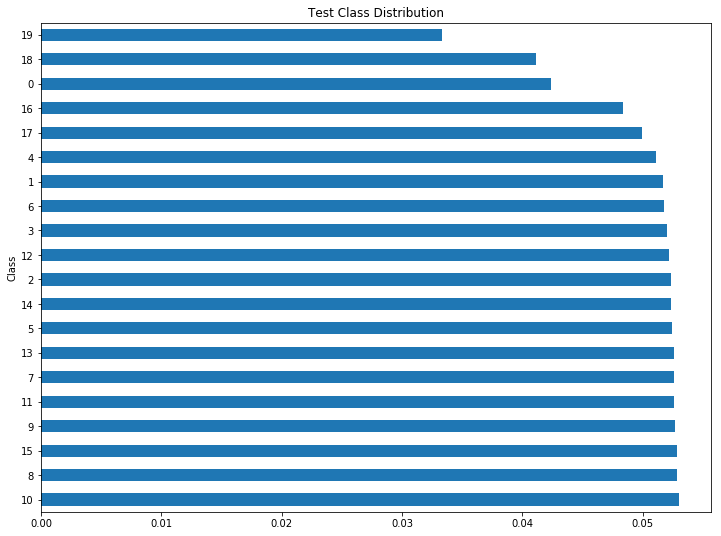

In [3]:
pd.Series(newsgroups_test.target).value_counts(normalize=True).\
plot(kind='barh', title='Test Class Distribution').set_ylabel('Class')

In [4]:
# Classes 
labels = newsgroups_test.target_names
for i in labels: print(i)

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


## Count Vectorizer
Tokenization and building vocabulary. The Scikit-learn count vectorizer converts a collection of text documents into a sparse matrix of token counts. When processing using the transform method, it transforms the documents into a document term matrix. The tfidftransformer transform a count matrix into a normalized tf-idf representation. Below shows the processing for both test and training data used in the following classifiers. 

In [5]:
vect = CountVectorizer().fit(newsgroups_train.data)
X_train = vect.transform(newsgroups_train.data)  # Bag of words 
print('X_train Shape: ', X_train.shape)

# TF-IDF 
# Reduce the weighting on common terms 
X_train_tfidf = TfidfTransformer().fit_transform(X_train)
print('X_train_idift Shape: ', X_train_tfidf.shape)

# Test data
vect_test = CountVectorizer().fit(newsgroups_test.data)
X_test = vect.transform(newsgroups_test.data)
X_test_tfidf = TfidfTransformer().fit_transform(X_test)

X_train Shape:  (11314, 101631)
X_train_idift Shape:  (11314, 101631)


## Classifier Comparison

When training classifiers on the training then predicting on the test set we can see the multinomial naive bayes and the support vector machine have about the same performance and similar run times. The accuracy is about 69% when using this split with the default SVM parameters and the NB model alpha set to 0.01 which was recommended from a referenced post. They had relatively fast run times still in the miliseconds. It's interesting to note the logistric regression model still performed competitively with about 67% accuracy however took a very long time to run compared to other classifiers. The runtimes for logistic regression, naive bayes and the support vector machine can be shown in the plot below, however because of the tremendous time difference the faster models are almost unnoticed. 

I also ran a random forest model that seems to perform better with an increased amount of trees, however it does not out of the box perform better than others. This might be a good one to try tuning later with a grid search. 

CPU times: user 9.51 s, sys: 1.81 s, total: 11.3 s
Wall time: 5.72 s
Logistic Regression Accuracy:  0.674853956452



CPU times: user 125 ms, sys: 46.4 ms, total: 171 ms
Wall time: 118 ms
NB Accuracy:  0.697955390335



CPU times: user 433 ms, sys: 6.35 ms, total: 439 ms
Wall time: 439 ms
SVM Accuracy:  0.694105151354



CPU times: user 1min 4s, sys: 594 ms, total: 1min 5s
Wall time: 1min 5s
Random forest Accuracy:  0.592405735528


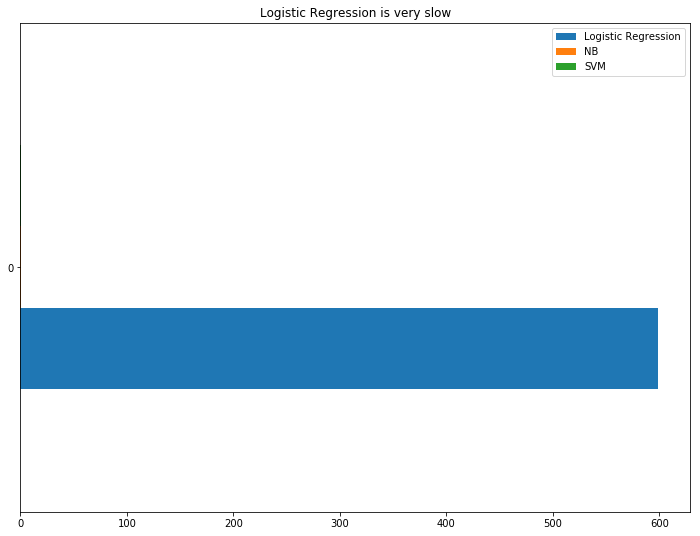

In [6]:
# Logistic Regression 
%time clf = LogisticRegression().fit(X_train_tfidf, newsgroups_train.target)
pred = clf.predict(X_test_tfidf)
print('Logistic Regression Accuracy: ', np.mean(pred == newsgroups_test.target))
print('\n\n')

# NB
%time clf = MultinomialNB(alpha=.01).fit(X_train_tfidf, newsgroups_train.target)
pred = clf.predict(X_test_tfidf)
print('NB Accuracy: ', np.mean(pred == newsgroups_test.target))
print('\n\n')

# SVM
%time clf = SGDClassifier().fit(X_train_tfidf, newsgroups_train.target)
pred = clf.predict(X_test_tfidf)
print('SVM Accuracy: ', np.mean(pred == newsgroups_test.target))
print('\n\n')

# RF
%time clf = RandomForestClassifier(n_estimators=100).fit(X_train_tfidf, newsgroups_train.target)
pred = clf.predict(X_test_tfidf)
print('Random forest Accuracy: ', np.mean(pred == newsgroups_test.target))

# GB -- too long
#clf = GradientBoostingClassifier().fit(X_train_tfidf, newsgroups_train.target)
#pred = clf.predict(X_test_tfidf.toarray())
#print('GB Accuracy: ', np.mean(pred == newsgroups_test.target))
# GB Accuracy:  0.596654275093

# Look at the run times
pd.DataFrame(data={'NB':[0.456], 
                   'Logistic Regression': [599], 
                   'SVM': [0.117]}).plot(kind='barh', title='Logistic Regression is very slow', )

In [ ]:
# K fold cv examples
# Logistic Regression
scores = cross_val_score(LogisticRegression(), X_train, newsgroups_train.target, cv=5)
print('Logistic Regression (wo tfidf) Mean CV accuracy: {:.2f}'.format(np.mean(scores)))

# Logistic Regression w/tfidf
scores = cross_val_score(LogisticRegression(), X_train_tfidf, newsgroups_train.target, cv=5)
print('Logistic Regression (tfidf) Mean CV accuracy: {:.2f}'.format(np.mean(scores)))

# NB 
scores = cross_val_score(MultinomialNB(alpha=.01), X_train, newsgroups_train.target, cv=5)
print('Multinomial NB (wo tfidf) Mean CV accuracy: {:.2f}'.format(np.mean(scores)))

scores = cross_val_score(MultinomialNB(alpha=.01), X_train_tfidf, newsgroups_train.target, cv=5)
print('Multinomial NB (tfidf )Mean CV accuracy (tf-idf): {:.2f}'.format(np.mean(scores)))

# SVM
scores = cross_val_score(SGDClassifier(), X_train, newsgroups_train.target, cv=5)
print('SVM (wo tfidf) Mean CV accuracy: {:.2f}'.format(np.mean(scores)))

scores = cross_val_score(SGDClassifier(), X_train_tfidf, newsgroups_train.target, cv=5)
print('SVM (tfidf) Mean CV accuracy (tf-idf): {:.2f}'.format(np.mean(scores)))

In [ ]:
# Example of running a sklearn pipeline 
clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                       alpha=1e-3, n_iter=5, random_state=42)),])
clf = clf.fit(newsgroups_train.data, newsgroups_train.target)

pred = clf.predict(newsgroups_test.data)
np.mean(pred == newsgroups_test.target)

## Results

For the evaluation and results I chose to further explore the SVM model as it performed well. When working with classification problems it's really helpful to view the confusion matrix to see possible correlations between the different classifications. Since we have so many categories it's difficult to view the out of the box confusion matrix from scikit-learn because notebooks in the browser line wrap too soon. I used a plotting method from the Introduction to Machine Learning with Python book package MgLearn from Andreas Muller. If you look at a few of the miss classifications when the predicted label was incorrect to the true label it's interesting to see how the model failed to identify. For an example we can see from the confusion matrix below that the incorrect label, talk.politics.misc was predicted fairly common when the true label was talk.politics.guns. This actually should be somewhat expected as the misc label might contain content that would fall into the talk.politics categories and best fits to what the labeled examples were. Or perhaps different labelers have mis categorized certain documents from the training set. Either way it's better the model mislabels in this circumstance compared to others that are more unrelated like comp.windows.x

The second valuable evaluation view is the classficiation report shown below. This gives us good at a glance metrics that we can use to help attribute some of the strengths and weaknesses of the model as well. Sometimes depending on your business or use case it's better to pick the model that favors how you want the strengths and weaknesses to lay on instead of shear accuracy. This is one thing to keep in mind when evaluation different models. For an example if we are looking to limit the number of false positives, we can look at the precision score for the sci.crpyt class and it has the highest score of 84%. There are a significant amount more of false positives for the class like alt.atheisim or talk.religion.misc. This might indicate something about the classification being very broad or unrepresented within the dataset. It's still important to note as we evaluate that this model doesn't perform very high on these categories. Recall is used to find all positive samples, like when we are looking to avoid false negatives. A good example is hockey for this model, it has high recall and high precision. We will recall a large portion of the documents and they will have high precision of being correctly attributed. 

In [7]:
# print(metrics.confusion_matrix(newsgroups_test.target, pred))
# too difficult to interpret
# SVM
clf = SGDClassifier().fit(X_train_tfidf, newsgroups_train.target)
pred = clf.predict(X_test_tfidf)

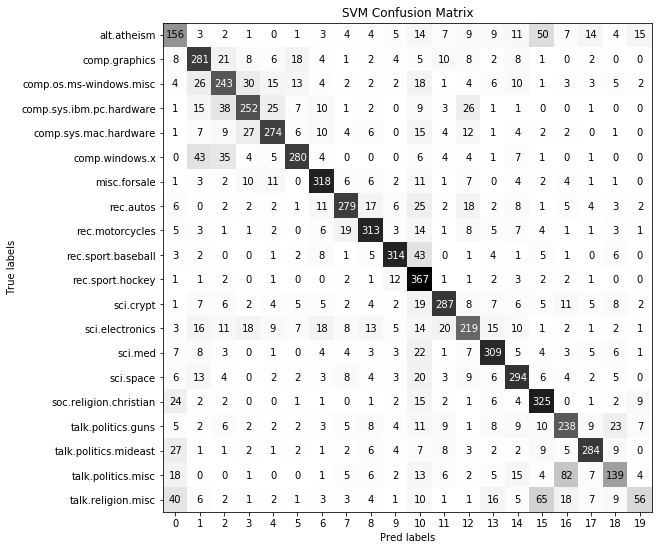

In [8]:
target_value_rep = []  # Quick replacement for the values corresponding to the targetnames.
for idx, i in enumerate(newsgroups_test.target_names):
    target_value_rep.append(idx)
    
scores_image = mglearn.tools.heatmap(metrics.confusion_matrix(newsgroups_test.target, pred), xlabel='Pred labels',
                                    ylabel='True labels', xticklabels=target_value_rep, yticklabels=newsgroups_test.target_names,
                                    cmap=plt.cm.gray_r, fmt="%d")
plt.title('SVM Confusion Matrix')
plt.gca().invert_yaxis()

                          precision    recall  f1-score   support

             alt.atheism       0.49      0.49      0.49       319
           comp.graphics       0.64      0.72      0.68       389
 comp.os.ms-windows.misc       0.62      0.62      0.62       394
comp.sys.ibm.pc.hardware       0.70      0.64      0.67       392
   comp.sys.mac.hardware       0.75      0.71      0.73       385
          comp.windows.x       0.80      0.71      0.75       395
            misc.forsale       0.76      0.82      0.79       390
               rec.autos       0.78      0.70      0.74       396
         rec.motorcycles       0.77      0.79      0.78       398
      rec.sport.baseball       0.84      0.79      0.81       397
        rec.sport.hockey       0.56      0.92      0.69       399
               sci.crypt       0.77      0.72      0.75       396
         sci.electronics       0.63      0.56      0.59       393
                 sci.med       0.76      0.78      0.77       396
         

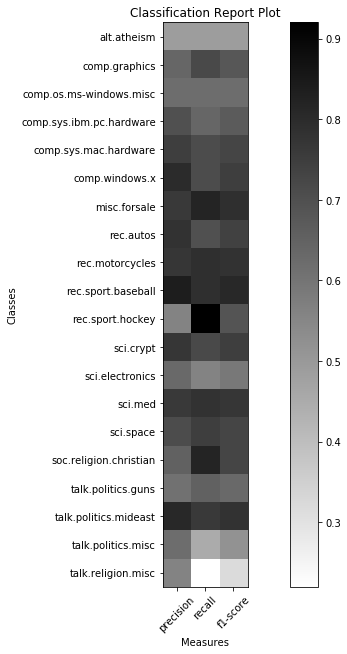

In [9]:
print(classification_report(newsgroups_test.target, pred, target_names=newsgroups_test.target_names))

def plot_classification_report(cr, title='Classification Report Plot', with_avg_total=False, cmap=plt.cm.gray_r):
    """ Plot example provided by: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
    """
    lines = cr.split('\n')  # parse 
    classes = []
    plotMat = []
    
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    
plot_classification_report(classification_report(newsgroups_test.target, pred, target_names=newsgroups_test.target_names))

## GloVe Embeddings with a Convolutional Neural Net

This example is based off of the Keras tutorial for using glove embeddings with keras models (https://github.com/fchollet/keras/blob/master/examples/pretrained_word_embeddings.py)

##### Setup: make sure to download the 6b glove embeddings and unzip. Also get access to the news20 file. I left these in the my working notebook directory.

```sh
wget http://nlp.stanford.edu/data/glove.6B.zip

mv ../Downloads/news20.tar.gz .
```

In [10]:
# Config
BASE_DIR = os.getcwd()
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000  # Limit needed for model
MAX_NB_WORDS = 20000  # Limit
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

#### Indexing GloVe Word Vectors
This builds the index mapping words within the embeddings set to their embedding vector. 

"GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."

Resource: https://nlp.stanford.edu/projects/glove/

In [11]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### Data Prep for 20 Newsgroups
This is listing the newsgroup directory, grabbing the labels from the path and storing into the labels index dict, the text goes into the text list and corresponding labels are in the labels list

In [12]:
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

In [13]:
print('Found %s texts.' % len(texts))
print('Sample Text: ', texts[10000][:300])
test_label = labels[10000]
category_name = newsgroups_test.target_names[test_label]
print('Sample Label: ', labels[10000], category_name)

Found 19997 texts.
Sample Text:  


Dean J. Falcione (posting from jrmst+8@pitt.edu) writes:
[I wrote:]

>>When the Pens got Mario, granted there was big publicity, etc, etc,
>>and interest was immediately generated.  Gretzky did the same thing for LA. 
>>However, imnsho, neither team would have seen a marked improvement in
>>atten
Sample Label:  10 rec.sport.hockey


#### Vectorize the text into a 2 dimensional int tensor

This needs to be done to input into the model. 

In [14]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)  # 2k
tokenizer.fit_on_texts(texts)  # accepts list of strings or generator
sequences = tokenizer.texts_to_sequences(texts)  # trans each text in a sequence of integers 

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pads all sequences to the same length (ie longest sequence)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels)) 
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


#### Train Validation Split

In [15]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

#### Embedding Matrix

Embedding layers are fed sequences of integers like ```(samples, indices)```. This is only to map integer inputs to vectors in the corresponding index in embedding matrix. Output is 3D tensor shape ```(samples, sequence_length, embedding_dim)```

In [16]:
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### Training
On an older i5 cpu it takes about 3.5 mins per epoch

1 Dimensional CNN with maxpooling

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

## Resources 

http://qwone.com/~jason/20Newsgroups/

https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

https://github.com/fchollet/keras/blob/master/examples/pretrained_word_embeddings.py

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

Introduction to Machine Learning with Python by Andreas Muller and Sarah Guido